# Plot Paloma data

## Imports and setup

In [1]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots

import wandb

rc_fonts = {
    "text.usetex": True,
    # "text.latex.preamble": "\n".join(
    #     [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    # ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x // 1000))


wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


True

## Get data from runs

In [2]:
api = wandb.Api()

RUN_SCALE = "tiny"

runs = [
    api.run("pico-lm/pico-decoder/lne20rc1"),  # pico decoder tiny
    api.run("pico-lm/pico-relora/6vhmv4aj"),  # pico relora tiny
    api.run("pico-lm/pico-decoder/kzcalg17"),  # small
    api.run("pico-lm/pico-relora/5urfvs2j"),
]

dfs: list[pd.DataFrame] = []


def _get_data(scale):
    for i in range(0, 20_001, 1_000):
        path = Path(f"blimp_results_{scale}/step_{i}.json")
        with path.open() as f:
            data = json.load(f)
        if "blimp" in data:
            data = data["blimp"]
        yield (i, data["accuracy"])


for ridx, run in enumerate(runs):
    df = pd.DataFrame(run.scan_history())
    is_decoder = ridx % 2 == 0
    df["Model"] = rf"\texttt{{pico-{'decoder' if is_decoder else 'relora'}}}"
    scale = "tiny" if ridx < 2 else "small"
    df["Scale"] = scale

    if is_decoder:
        df_to_merge = pd.DataFrame(_get_data(scale), columns=["trainer/global_step", "eval/blimp"])
        df = pd.merge(df, df_to_merge, how="left", on="trainer/global_step")

    dfs.append(df)

In [5]:
runtime_data = pd.concat(dfs, ignore_index=True)


runtime_data.rename(
    columns={"eval/paloma": "PPL", "train/loss": "Loss", "eval/blimp": "BLiMP"}, inplace=True
)

runtime_data = runtime_data.drop(columns=runtime_data.filter(regex="^blimp/").columns)
runtime_data = runtime_data.drop(columns=runtime_data.filter(regex="^relora/").columns)


runtime_data = runtime_data[runtime_data["trainer/global_step"] <= 20_001]

In [6]:
f_run_data = runtime_data[
    runtime_data["PPL"].notna() | runtime_data["Loss"].notna() | runtime_data["BLiMP"].notna()
]

loss_data = (
    f_run_data[["trainer/global_step", "Loss", "Model", "Scale"]].dropna().rename(columns={"Loss": "Value"})
)
loss_data["Metric"] = "Loss"

ppl_data = (
    f_run_data[["trainer/global_step", "PPL", "Model", "Scale"]].dropna().rename(columns={"PPL": "Value"})
)
ppl_data["Metric"] = "PPL"

blimp_data = (
    f_run_data[["trainer/global_step", "BLiMP", "Model", "Scale"]]
    .dropna()
    .rename(columns={"BLiMP": "Value"})
)
blimp_data["Metric"] = "BLiMP"

# Concatenate the dataframes
combined_data = pd.concat([loss_data, ppl_data, blimp_data], ignore_index=True)
# combined_data = combined_data[combined_data["trainer/global_step"] <= 20_000]

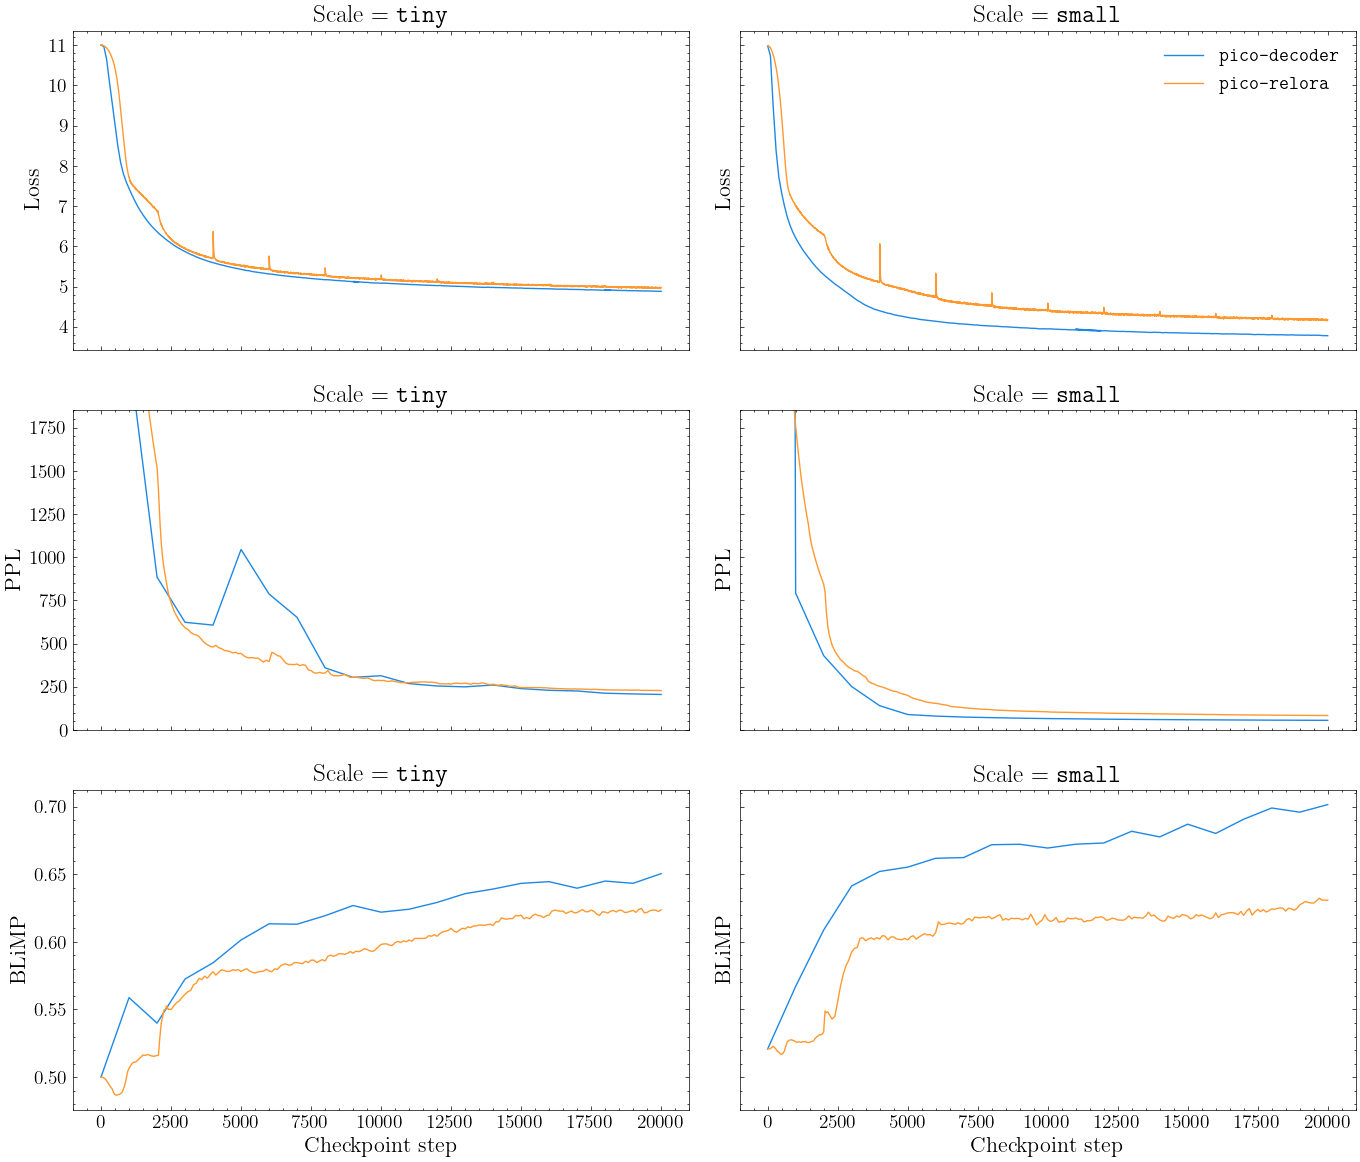

In [13]:
plt.style.use(["science"])

plt.rcParams.update(
    {
        "font.size": 16,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "figure.titlesize": 20,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    }
)

# Setup
colors = ["#1E88E5", "#FF992F"]
models = sorted(combined_data["Model"].unique().tolist())
palette = dict(zip(models, colors))

# Clean data
data = combined_data.drop_duplicates()

# Unique scales and metrics
scales = data["Scale"].unique()
metrics = data["Metric"].unique()
n_rows = len(metrics)
n_cols = len(scales)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 4), sharex=True, sharey="row")

# If axes is 1D, make it 2D for uniform access
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)
if n_cols == 1:
    axes = np.expand_dims(axes, axis=1)

# Plotting loop
for i, metric in enumerate(metrics):
    for j, scale in enumerate(scales):
        ax = axes[i, j]
        subset = data[(data["Metric"] == metric) & (data["Scale"] == scale)]

        for model in models:
            model_data = subset[subset["Model"] == model]
            ax.plot(
                model_data["trainer/global_step"],
                model_data["Value"],
                label=model,
                color=palette[model],
                linewidth=1,
            )

        # Y-axis labels
        if metric.lower() == "loss":
            ax.set_ylabel("Loss")
        elif metric.lower() == "ppl":
            ax.set_ylabel("PPL")
        else:
            ax.set_ylabel("BLiMP")

        # Titles
        if scale.lower() == "tiny":
            ax.set_title(r"Scale = \texttt{tiny}")
        elif scale.lower() == "small":
            ax.set_title(r"Scale = \texttt{small}")

        # Custom y-limits
        axid = i * n_cols + j
        if axid in (2, 3):
            ax.set_ylim(0, 1850)

        # Legend on specific subplot
        if axid == 1:
            ax.legend(loc="upper right", bbox_to_anchor=(1, 1))

# X-axis label on bottom row only
for ax in axes[-1, :]:
    ax.set_xlabel("Checkpoint step")

plt.tight_layout()
plt.savefig("../paper-graphs/training-gpu-hrs.pdf", bbox_inches="tight")
plt.show()